# Transfer Learning with TensorFlow Part 3: Scaling up (food vision 101)

We have seen how good transfer learning is to continue improving models. Now we scale up to all the classes but with 10% of the data. So 101 classes. We try to beat the official paper with 50.5%

## Creating helper functions

In previous notebooks, we've created some helper funtions to do different tasks. 

In [1]:
from helper_functions import *

## 101 Food Classes: working with less data

Our goal is to beat the paper, as I wrote above but the dude on the video has serious ADHD and wants to make everything uberduper blahbalh

In [2]:
import tensorflow as tf

In [8]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [9]:
img_size = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=img_size,
                                                                            label_mode='categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=img_size,
                                                                label_mode='categorical',
                                                                shuffle=False) # Dont shuffle, we will do shit with it

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a  big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation alyer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time) 

In [ ]:
# Create a checkpoint callback
checkpoint_path = '101_classes_percent_data_model_checkpoint'

def create_checkpoint_callback(folder, checkpoint_file='101_classes_10_percent'):
  checkpoint_path = folder + '/' + checkpoint_file
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)
  return checkpoint_callback

In [90]:
# Create data augmentation layer to incorporate it right into the model

def create_augmentation_layer():
  aug = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                             tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                             tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                             tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                             tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
  ], name='augmentation_layers')

  return aug

  

In [91]:
data_augmentation = create_augmentation_layer()

In [8]:
# Setup thse base model and freeze its layer
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=img_size+(3,), name='input_layer')

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile and fit

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback('Tensorboards', '06_model1'), create_checkpoint_callback()])

Saving TensorBoard log files to: Tensorboards/06_model1/20220118-150338


c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
237/237 [==============================] - 243s 924ms/step - loss: 3.4574 - accuracy: 0.2436 - val_loss: 2.5907 - val_accuracy: 0.4246
Epoch 2/5
237/237 [==============================] - 126s 529ms/step - loss: 2.3396 - accuracy: 0.4623 - val_loss: 2.1904 - val_accuracy: 0.4680
Epoch 3/5
237/237 [==============================] - 144s 608ms/step - loss: 1.9821 - accuracy: 0.5287 - val_loss: 2.0519 - val_accuracy: 0.4779
Epoch 4/5
237/237 [==============================] - 154s 646ms/step - loss: 1.7562 - accuracy: 0.5769 - val_loss: 1.9632 - val_accuracy: 0.4997
Epoch 5/5
237/237 [==============================] - 122s 514ms/step - loss: 1.5980 - accuracy: 0.6115 - val_loss: 1.8841 - val_accuracy: 0.5113


In [ ]:
# Evaluate on all test data
pre_fine_tune_results = model_1.evaluate(test_data)

790/790 [==============================] - 344s 436ms/step - loss: 1.7073 - accuracy: 0.5571


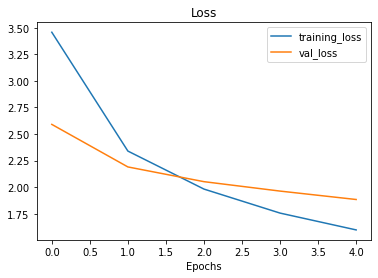

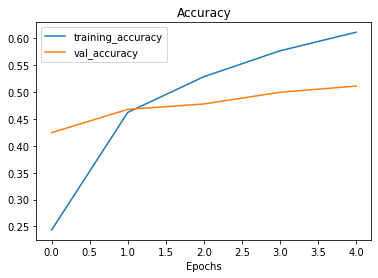

In [ ]:
plot_loss_curves(history_1)

It looks like our model is overfitting. The curves should be closer together.

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.Trainable = True

# Refreeze all except the 5 last

for layer in base_model.layers[:-5]:
  layer.Trainable = True

In [ ]:
# Recompile with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

# Fit the model again
history_1_finetuned = model_1.fit(train_data_10_percent,
                                  epochs=10,
                                  validation_data=test_data,
                                  validation_steps=(0.15*len(test_data)),
                                  initial_epoch=5,
                                  callbacks=[create_tensorboard_callback('Tensorboards', '06_model1'), create_checkpoint_callback()])

Saving TensorBoard log files to: Tensorboards/06_model1/20220118-154139
Epoch 6/10
237/237 [==============================] - 104s 420ms/step - loss: 1.4368 - accuracy: 0.6532 - val_loss: 1.9025 - val_accuracy: 0.5068
Epoch 7/10
237/237 [==============================] - 98s 412ms/step - loss: 1.4120 - accuracy: 0.6669 - val_loss: 1.9003 - val_accuracy: 0.5076
Epoch 8/10
237/237 [==============================] - 98s 410ms/step - loss: 1.3959 - accuracy: 0.6681 - val_loss: 1.8935 - val_accuracy: 0.5105
Epoch 9/10
237/237 [==============================] - 111s 463ms/step - loss: 1.3739 - accuracy: 0.6743 - val_loss: 1.8904 - val_accuracy: 0.5108
Epoch 10/10
237/237 [==============================] - 97s 408ms/step - loss: 1.3647 - accuracy: 0.6758 - val_loss: 1.8844 - val_accuracy: 0.5118


In [ ]:
tuned_results = model_1.evaluate(test_data)

790/790 [==============================] - 265s 336ms/step - loss: 1.6700 - accuracy: 0.5643


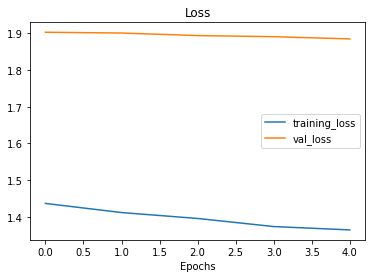

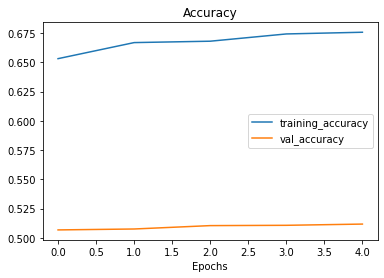

In [ ]:
plot_loss_curves(history_1_finetuned)

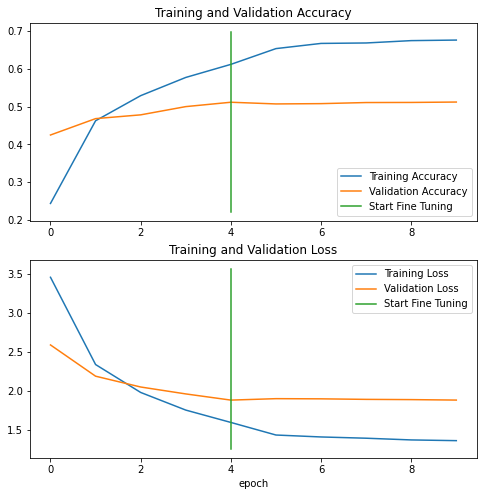

In [ ]:
compare_historys(history_1, history_1_finetuned)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere else

In [ ]:
model_1.save('Tensorflow_course/101_food_classes_10_percent')

c:\users\robin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: Tensorflow_course/101_food_classes_10_percent\assets


In [ ]:
# Loaded_model = tf.keras.load_model('file_name')

## Evaluating the performance of the big dog model across different classes

Lets make som predictions and visualize them

In [ ]:
preds_probs = model_1.predict(test_data, verbose=1) 

790/790 [==============================] - 127s 159ms/step


In [ ]:
preds_probs.shape

(25250, 101)

Can load the weights in from yesterdays session

In [9]:
# Load in wiehgts
loaded_model = tf.keras.models.load_model('Tensorflow_course/101_food_classes_10_percent/')

In [10]:
# To load checkpoints we need to create a new model instance
base_model.Trainable = True

for layer in base_model.layers[:-5]:
  layer.Trainable = False

In [ ]:
checkpoint_model = model_1.load_weights('101_classes_percent_data_model_checkpoint')

In [ ]:
# Check both for a short duration:
loaded_eval = loaded_model.evaluate(test_data, steps=10)

10/10 [==============================] - 23s 207ms/step - loss: 2.5848 - accuracy: 0.2719


Found out that I need to compile it again if I load it from checkpoint. Do not need that when I run save_model functionality

In [11]:
base_model.trainable = True
for i, layer in enumerate(base_model.layers[:-5]):
  layer.trainable = False

In [ ]:
for layer in model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
augmentation_layers True
efficientnetb0 True
global_average_pooling2d True
output_layer True


In [12]:
preds_probs = loaded_model.predict(test_data)

In [ ]:
preds_probs[0]

array([2.88761616e-01, 3.64857813e-04, 1.96028113e-01, 1.09042128e-06,
       6.92059184e-05, 5.36215957e-05, 9.62444465e-04, 9.41977196e-05,
       3.12756412e-02, 6.55101845e-03, 3.43508873e-05, 8.45074173e-05,
       1.55262658e-02, 9.61338174e-06, 5.03548123e-02, 5.88677765e-04,
       1.16174815e-04, 4.00168728e-03, 2.00931565e-03, 6.33556265e-05,
       3.46427492e-04, 3.34325596e-04, 3.85798136e-04, 5.36070438e-04,
       5.81380678e-04, 3.69266537e-03, 2.50249309e-03, 2.13587831e-04,
       9.91515815e-02, 5.12279430e-03, 5.75926715e-05, 1.15844293e-03,
       2.27300217e-03, 1.27603053e-05, 4.80309874e-03, 9.09732917e-05,
       1.24111644e-03, 1.90873875e-03, 3.04014757e-02, 7.75570879e-05,
       5.90144482e-04, 1.70171645e-03, 2.83382437e-03, 7.66160956e-05,
       4.93062078e-04, 3.72260896e-04, 1.89436157e-03, 7.04103848e-04,
       3.62850587e-05, 2.33933441e-02, 1.42484938e-03, 1.25901453e-04,
       2.39195861e-02, 8.59642681e-03, 5.73028592e-05, 3.47141623e-02,
      

Our model outputs a prediction probability array for each sample passed to the predict method

In [ ]:
np.argmax(preds_probs[0])

0

In [ ]:
print(f'What is the prediction of this?: {np.argmax(preds_probs[0])}')

What is the prediction of this?: 0


In [ ]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
test_data.class_names[0]

'apple_pie'

In [27]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46,  9,  0], dtype=int64)

In [ ]:
len(pred_classes)

25250

How to compare actual label with predicted label? I think we get the class_names in an array, and then we plot the actual data with the predicted data

In [13]:
# First we have to have a class_names array
class_names = test_data.class_names

In [14]:
# To get our test labels we need to unravel our batch test data
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

Wtf is he talking about. One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [28]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_labels, pred_classes)
score # This should be the same as the evaluate thing

0.5642772277227722

## Let's get visual: making a confusion_matrix

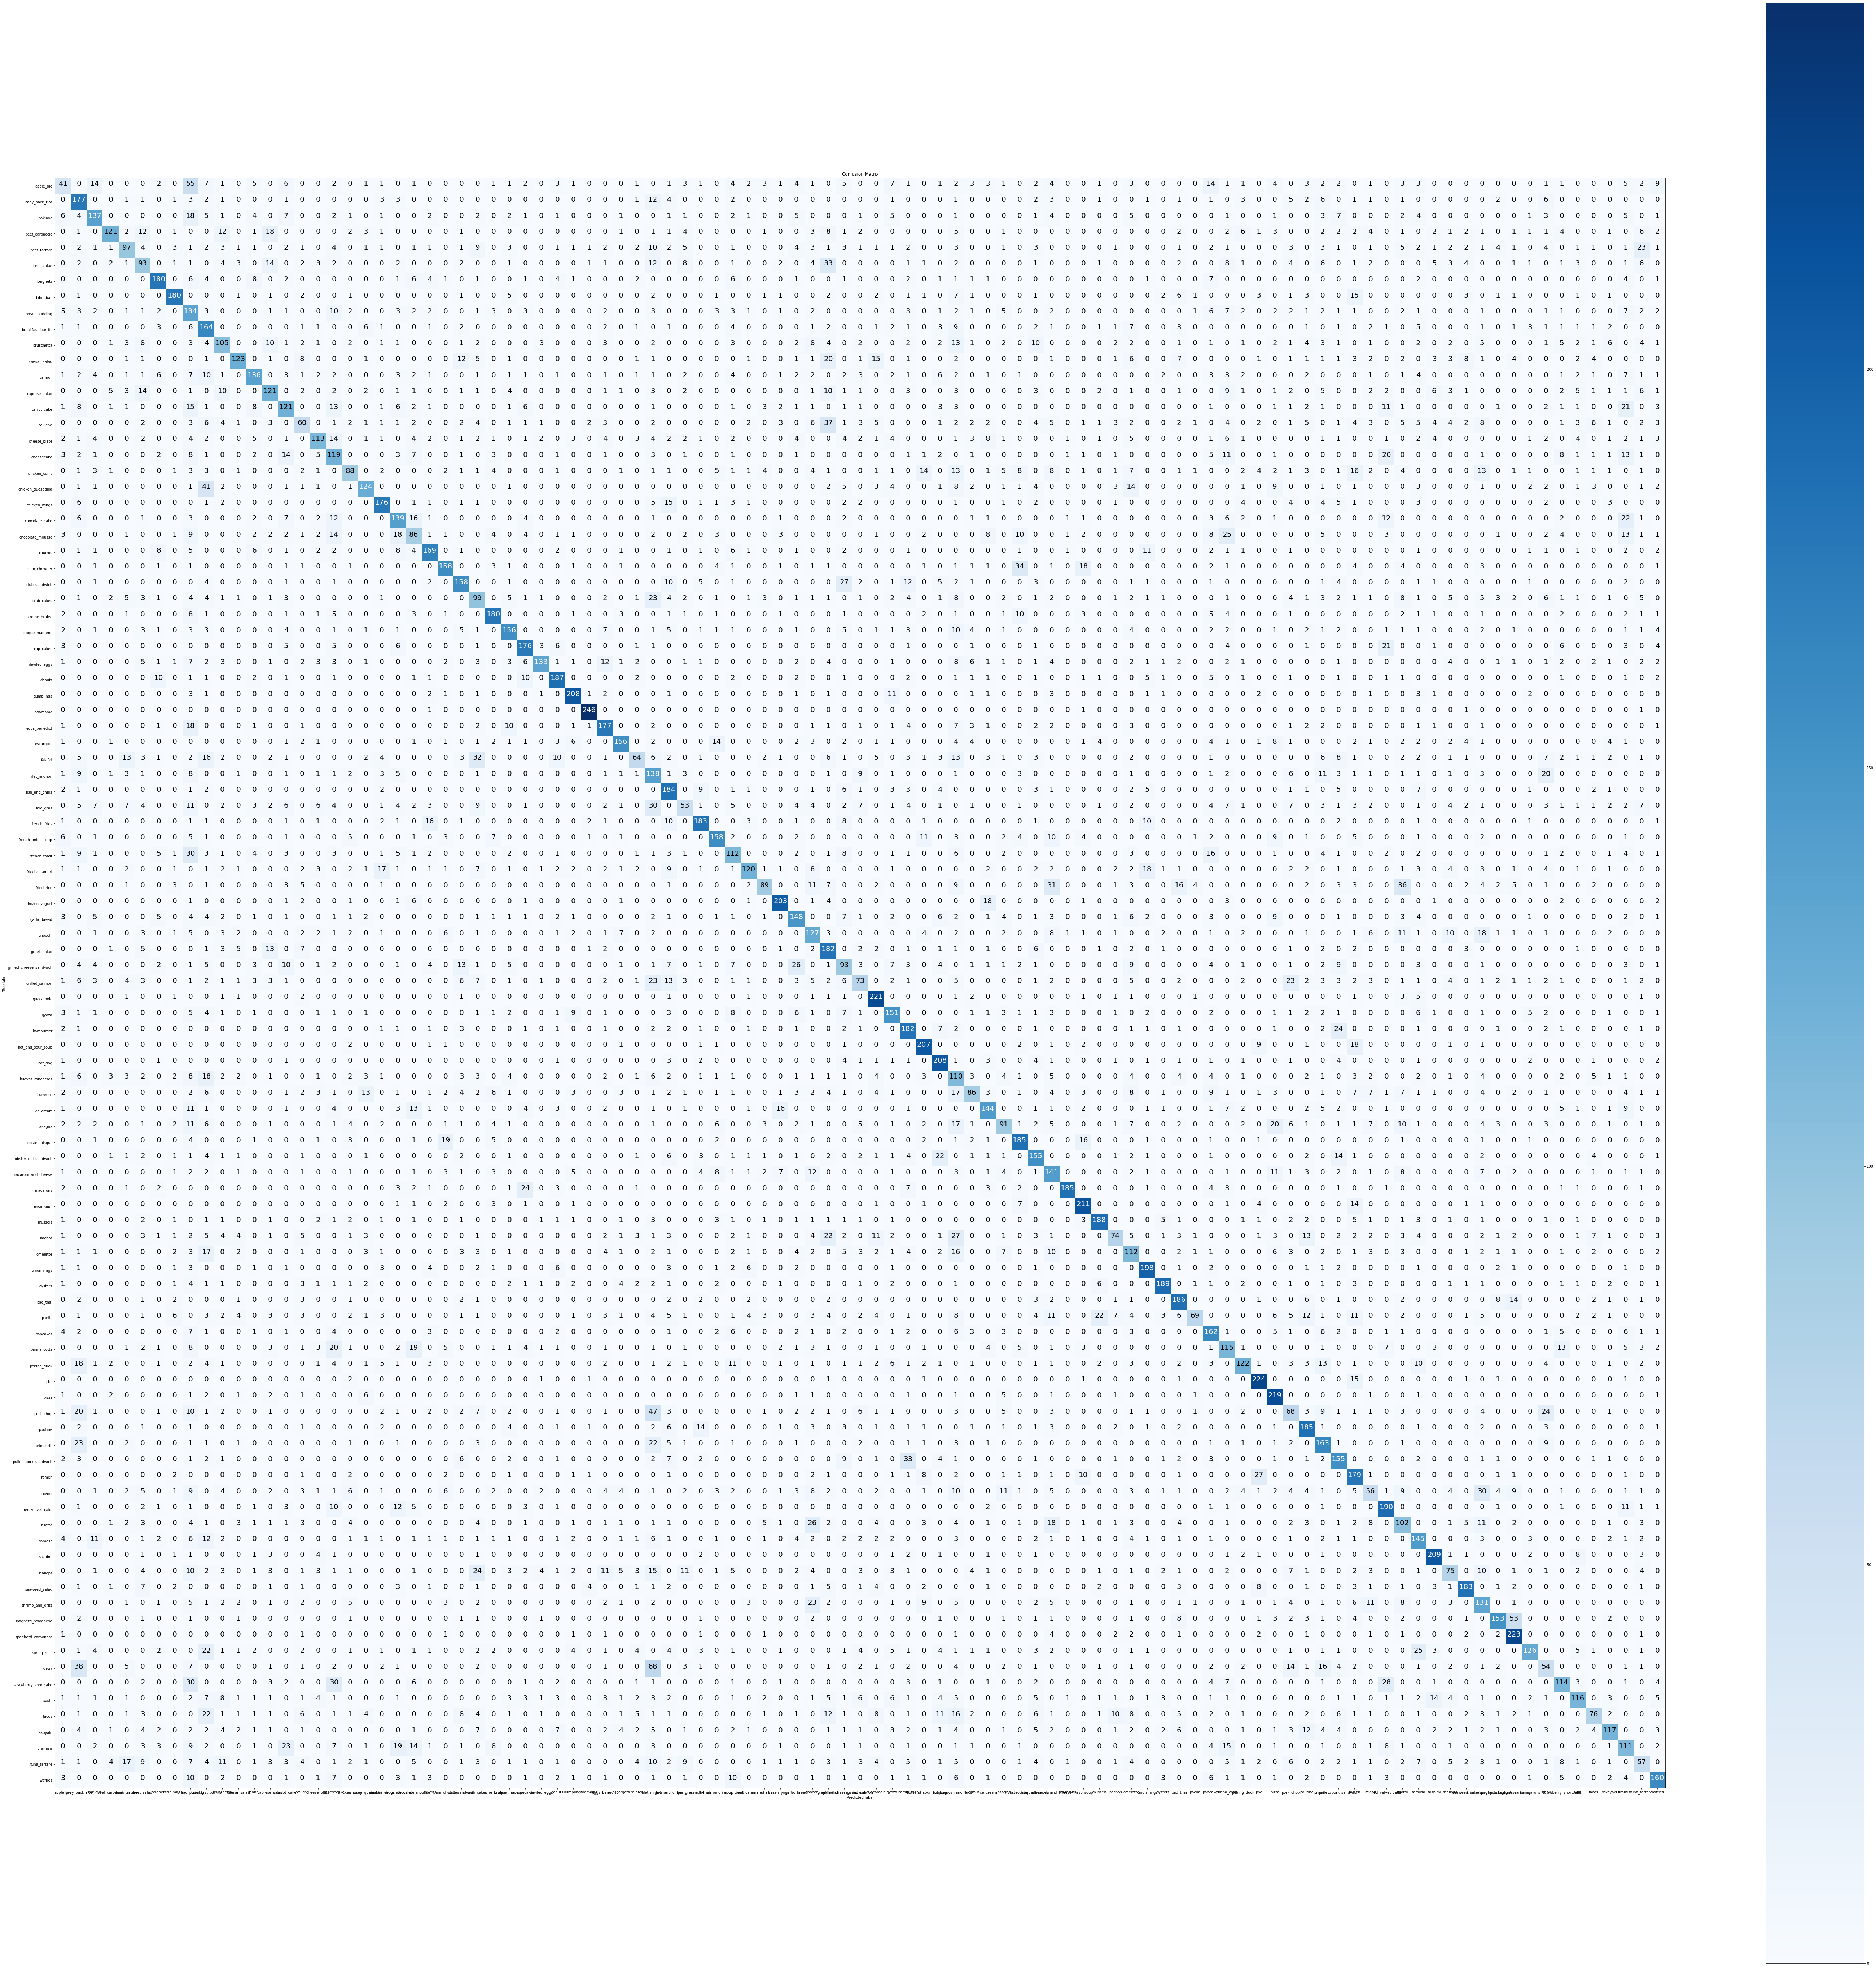

In [ ]:
from helper_functions import *
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_names,
                      figsize=(100, 100),
                      text_size=20) # Got an errror when I had class_names as an np.array

In [15]:
# We need to make some changes to our confusion matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

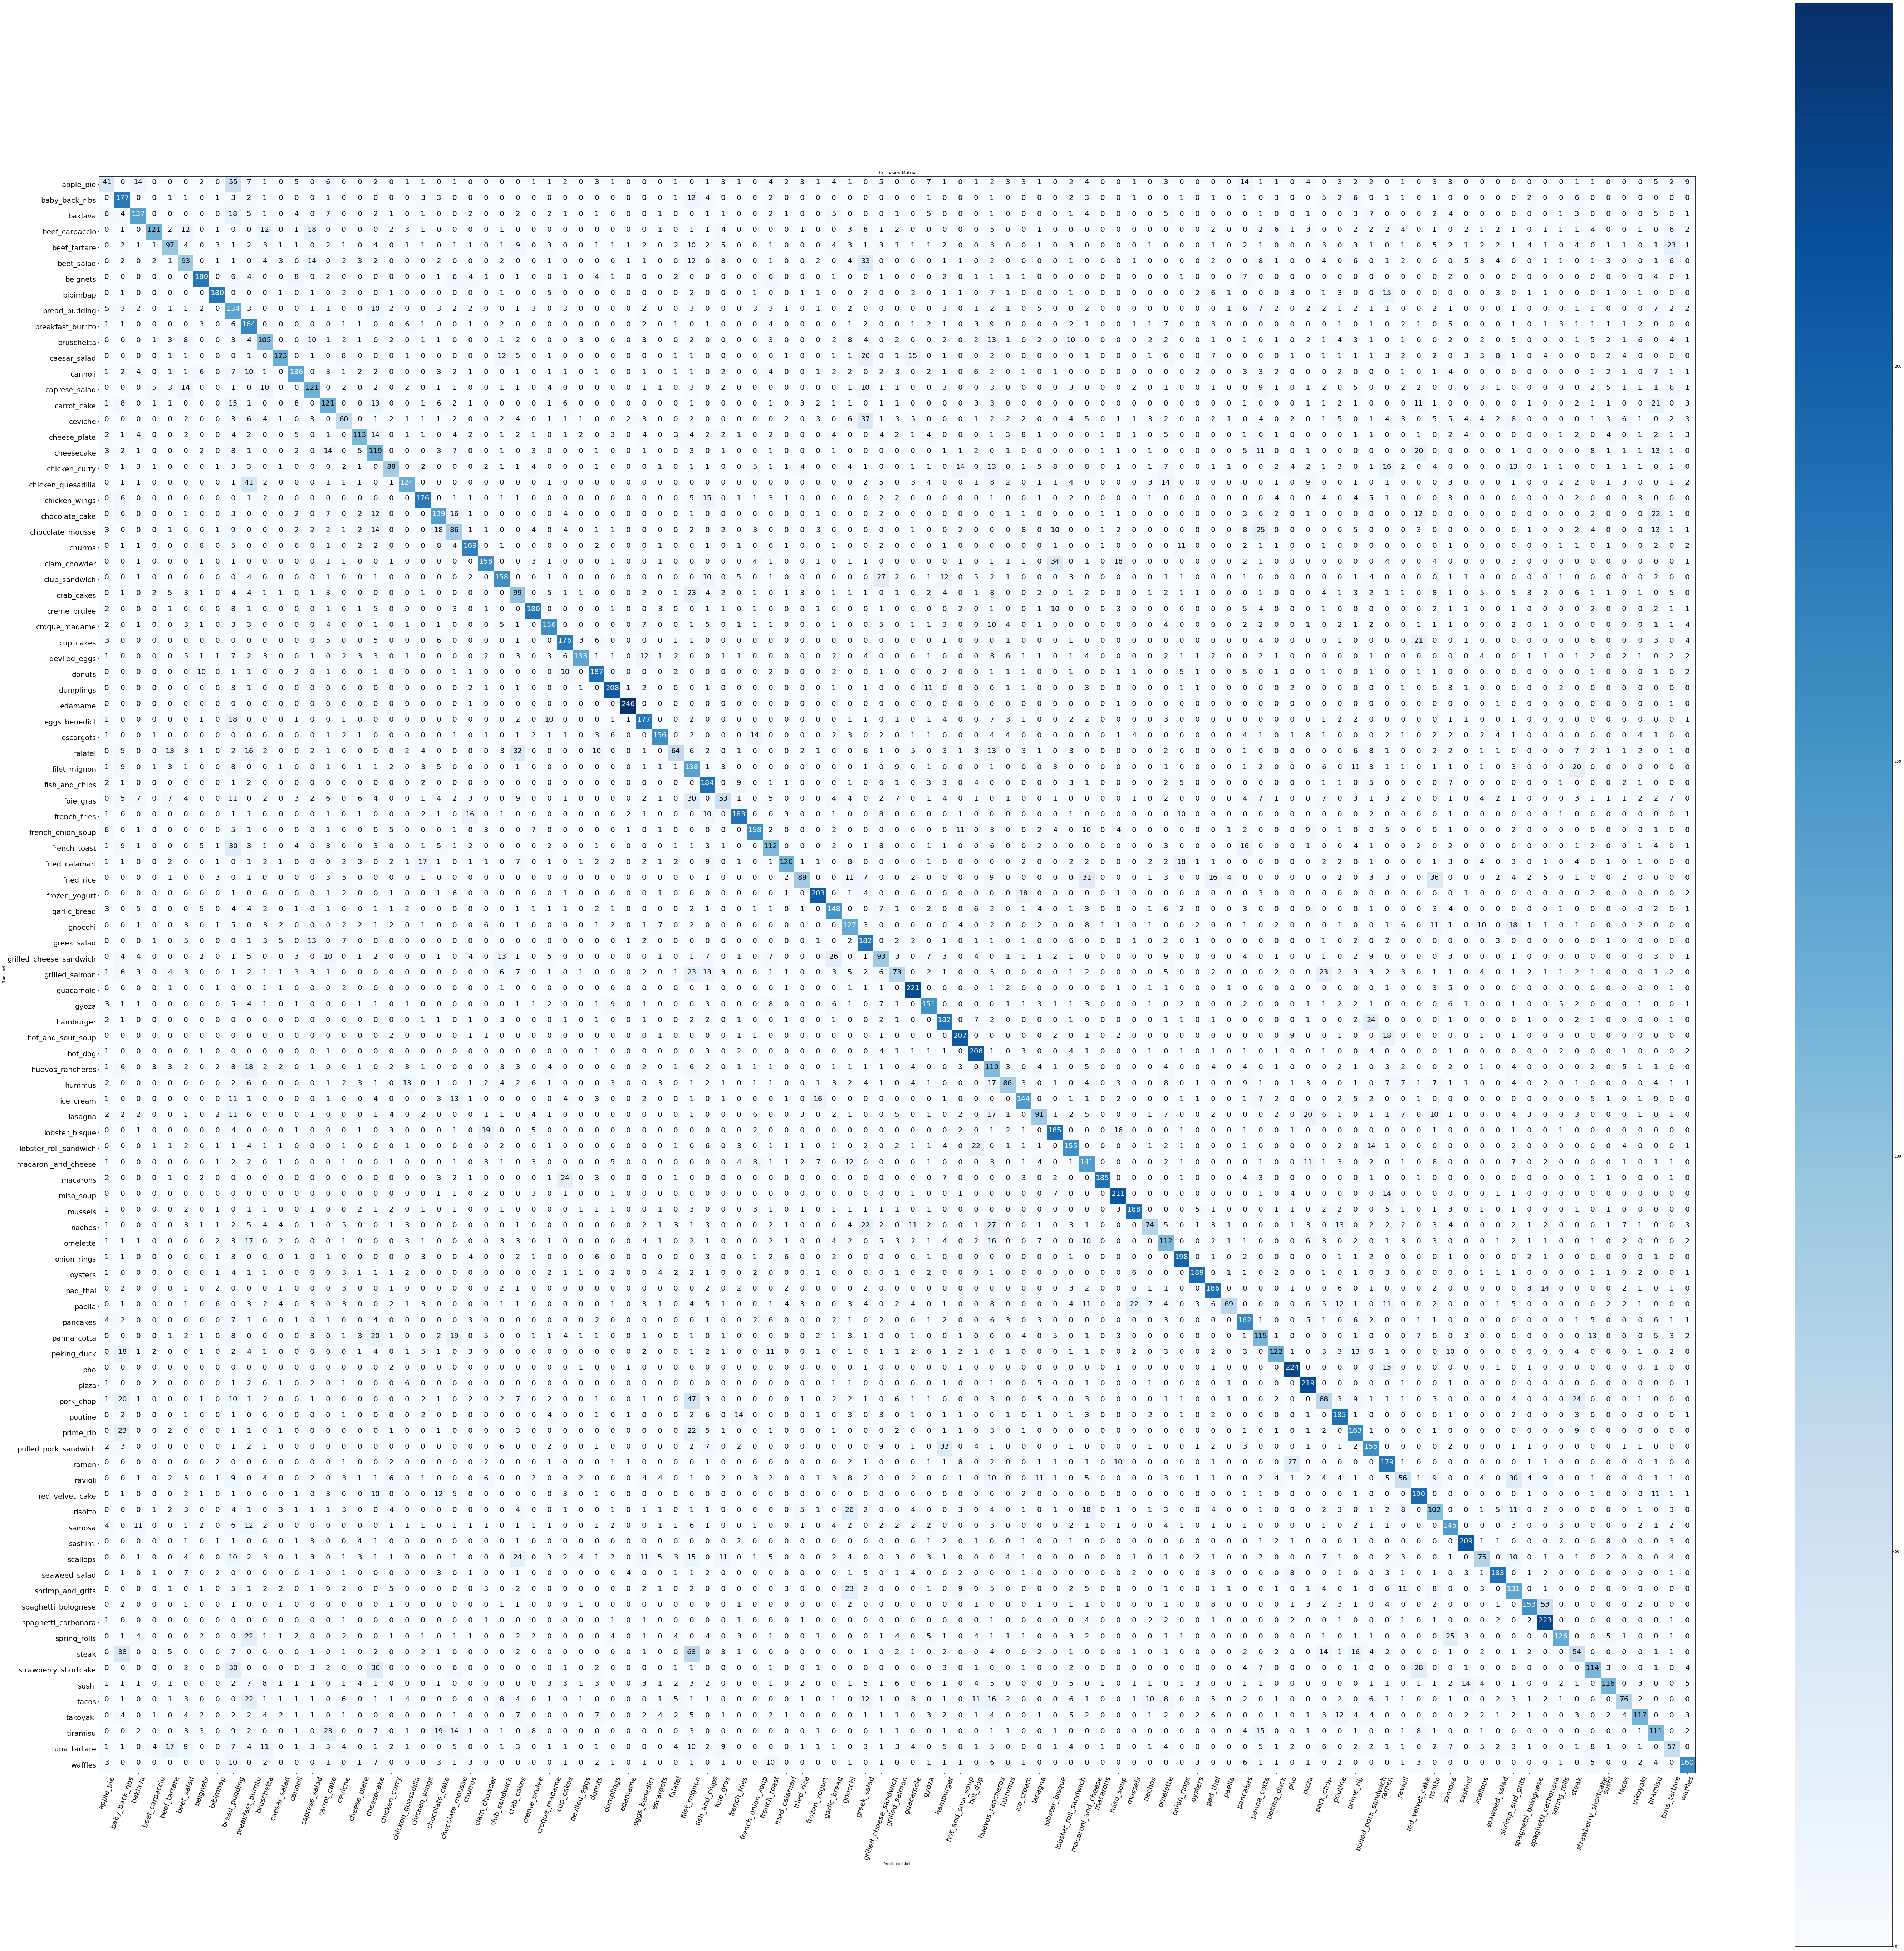

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep evaluating stuff

Scikit-learn is very good. Use it. THat is the basic jizzd of what he is saying. But he spends 6 lines explaining it

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.16      0.22       250
           1       0.45      0.71      0.55       250
           2       0.62      0.55      0.58       250
           3       0.80      0.48      0.60       250
           4       0.52      0.39      0.44       250
           5       0.40      0.37      0.39       250
           6       0.72      0.72      0.72       250
           7       0.81      0.72      0.76       250
           8       0.23      0.54      0.32       250
           9       0.35      0.66      0.46       250
          10       0.48      0.42      0.45       250
          11       0.72      0.49      0.59       250
          12       0.64      0.54      0.59       250
          13       0.53      0.48      0.51       250
          14       0.48      0.48      0.48       250
          15       0.38      0.24      0.29       250
          16       0.63      0.45      0.53       250
          17       0.37    

In [30]:
# Get a dictonary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3228346456692913,
  'recall': 0.164,
  'f1-score': 0.21750663129973472,
  'support': 250},
 '1': {'precision': 0.45038167938931295,
  'recall': 0.708,
  'f1-score': 0.5505443234836703,
  'support': 250},
 '2': {'precision': 0.6227272727272727,
  'recall': 0.548,
  'f1-score': 0.5829787234042554,
  'support': 250},
 '3': {'precision': 0.7960526315789473,
  'recall': 0.484,
  'f1-score': 0.6019900497512438,
  'support': 250},
 '4': {'precision': 0.521505376344086,
  'recall': 0.388,
  'f1-score': 0.444954128440367,
  'support': 250},
 '5': {'precision': 0.4043478260869565,
  'recall': 0.372,
  'f1-score': 0.3875,
  'support': 250},
 '6': {'precision': 0.7228915662650602,
  'recall': 0.72,
  'f1-score': 0.7214428857715431,
  'support': 250},
 '7': {'precision': 0.8108108108108109,
  'recall': 0.72,
  'f1-score': 0.7627118644067797,
  'support': 250},
 '8': {'precision': 0.22635135135135134,
  'recall': 0.536,
  'f1-score': 0.3182897862232779,
  'support': 250},
 '9':

Let's plot all of our classes F1-scores

In [31]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary item
for k, v in classification_report_dict.items():
  if k == 'accuracy': # Stop onece we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.21750663129973472,
 'baby_back_ribs': 0.5505443234836703,
 'baklava': 0.5829787234042554,
 'beef_carpaccio': 0.6019900497512438,
 'beef_tartare': 0.444954128440367,
 'beet_salad': 0.3875,
 'beignets': 0.7214428857715431,
 'bibimbap': 0.7627118644067797,
 'bread_pudding': 0.3182897862232779,
 'breakfast_burrito': 0.45938375350140054,
 'bruschetta': 0.4458598726114649,
 'caesar_salad': 0.5857142857142856,
 'cannoli': 0.5887445887445888,
 'caprese_salad': 0.5073375262054508,
 'carrot_cake': 0.4801587301587301,
 'ceviche': 0.29411764705882354,
 'cheese_plate': 0.5280373831775701,
 'cheesecake': 0.4131944444444444,
 'chicken_curry': 0.4292682926829268,
 'chicken_quesadilla': 0.5662100456621004,
 'chicken_wings': 0.7054108216432865,
 'chocolate_cake': 0.5377176015473888,
 'chocolate_mousse': 0.36363636363636365,
 'churros': 0.6869918699186993,
 'clam_chowder': 0.6680761099365752,
 'club_sandwich': 0.6257425742574257,
 'crab_cakes': 0.37858508604206503,
 'creme_brulee': 0.7258

In [32]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [ ]:
f1_scores.head()

class_names  f1-score
33     edamame  0.959064
63    macarons  0.835214
75         pho  0.816029
32   dumplings  0.809339
86     sashimi  0.806950

array([[<AxesSubplot:title={'center':'f1-score'}>]], dtype=object)

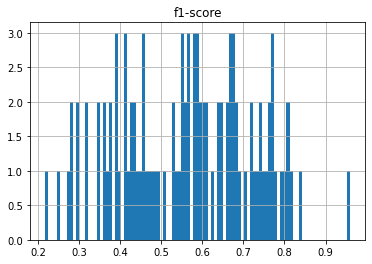

In [ ]:
f1_scores.hist(bins=len(class_names),
               column='f1-score')

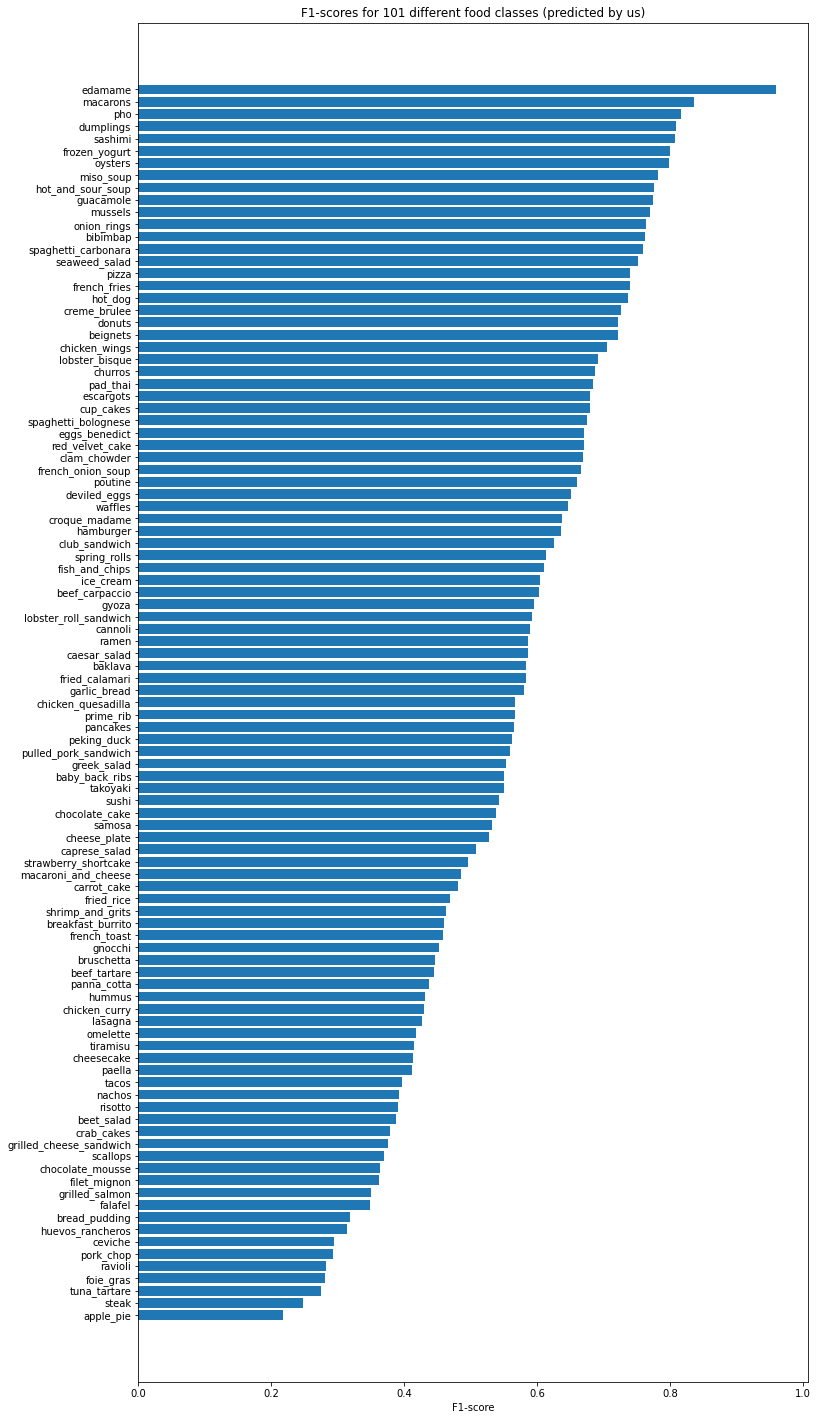

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 different food classes (predicted by us)')
ax.invert_yaxis()

# Challenge: add values to the end of each bar of what the actual f1-score is.
# Hint: use the autolabel function form matplotlib

In [ ]:
def autolabel(scores):
  for score in scores:
    width = score.get_width()
   
    ax.text(1.05 * width, score.get_y() + (score.get_height() / 2.),
            '%d' % int(width),
            ha='center', va='top')
    

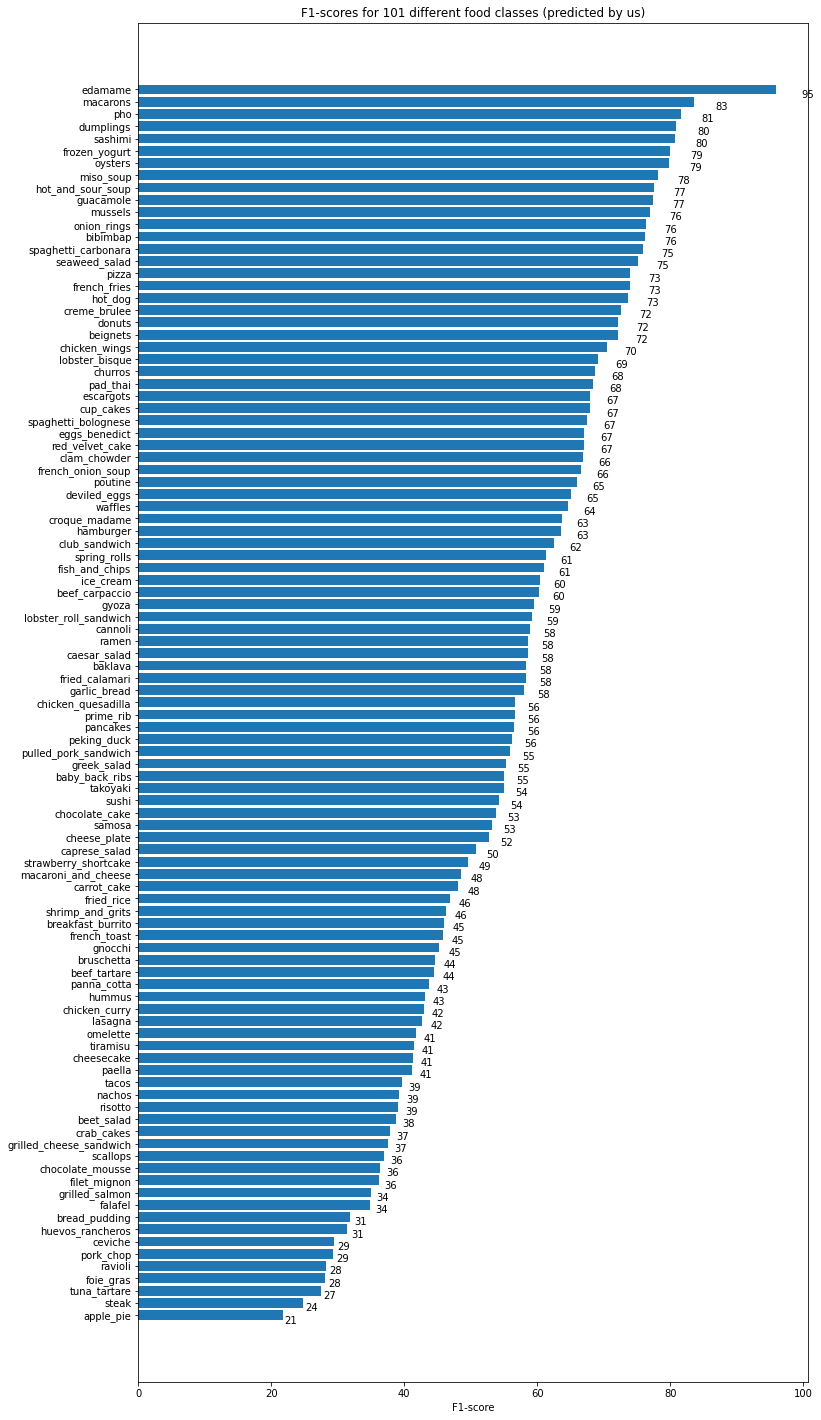

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values * 100)
autolabel(scores)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 different food classes (predicted by us)')
ax.invert_yaxis()


# Challenge: add values to the end of each bar of what the actual f1-score is.
# Hint: use the autolabel function form matplotlib

In [ ]:
for score in scores[:10]:
  print(score.get_y() + (score.get_height() / 2.), score.get_y(), score.get_height() )

0.0 -0.4 0.8
1.0 0.6 0.8
2.0 1.6 0.8
3.0 2.6 0.8
4.0 3.6 0.8
5.0 4.6 0.8
6.0 5.6 0.8
7.0 6.6 0.8
8.0 7.6 0.8
9.0 8.6 0.8


## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset

Create some function to read and turn the image into a tensor.
Using tf.io.read_file() and tf.io.decode_image()

In [16]:
# Create a function to load and prepare images
def load_and_prep_image(filname, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, num_channels=3)
  
  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filname)

  # Decode the image
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale yes/no?
  if scale:
    return img/255.
  else:
    return img
  

Now we have a function to load our images. Let's make a function to visualize the images

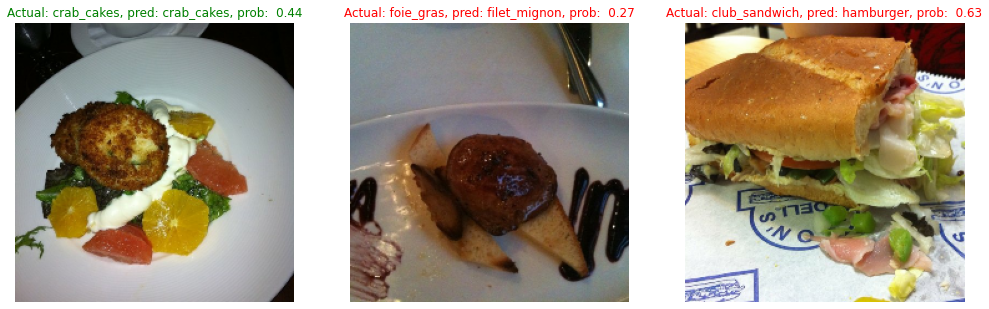

In [ ]:
# Make predictions on a series of random images
import os 
import random

plt.figure(figsize=(17, 14))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  
  plt.title(f'Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max(): .2f}', c=title_color)
  plt.axis('off')

## Findind the most wron predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names
3. Use our dataframe to find all the worng predictions (where the gournd truth label doesn't match the prediction)
4. Sort the dataframe based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highest predictions probabilities with the highest probabilities

In [17]:
# 1. Get the paths
list_of_files = tf.data.Dataset.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle=False)
list_of_files

<TensorSliceDataset shapes: (), types: tf.string>

In [18]:
filepaths = []

for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())


In [19]:
filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [42]:
# Create a dataframe of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'predicted_classes': pred_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'predicted_classname': [class_names[i] for i in pred_classes]})

In [43]:
pred_df.head()

img_path  y_true  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0   

   predicted_classes  pred_conf y_true_classname predicted_classname  
0                  0   0.288762        apple_pie           apple_pie  
1                  0   0.760126        apple_pie           apple_pie  
2                  0   0.181811        apple_pie           apple_pie  
3                 38   0.118977        apple_pie      fish_and_chips  
4                  8   0.235405        apple_pie       bread_pudding

In [44]:
pred_df.assign(Match = lambda x: x['y_true'] == x['predicted_classes'])

img_path  y_true  \
0      b'101_food_classes_10_percent\\test\\apple_pie...       0   
1      b'101_food_classes_10_percent\\test\\apple_pie...       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0   
...                                                  ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100   

       predicted_classes  pred_conf y_true_classname predicted_classname  \
0                      0   0.288762        apple_pie           apple_pie   
1                      0   0.760126        apple_pie           apple_pie   
2                      0   0.181811        apple_pie           apple_pie   
3                     38   0.118977        apple_pie      fish_and_chips   
4                      8   0.235405        apple_pie       bread_pudding   
...                  ...        ...              ...                 ...   
25245                100   0.823108          waffles             waffles   
25246                100   0.706155          waffles             waffles   
25247                 56   0.318164          waffles    huevos_rancheros   
25248                100   0.190325          waffles             waffles   
25249                100   0.278124          waffles             waffles   

       Match  
0       True  
1       True  
2       True  
3      False  
4      False  
...      ...  
25245   True  
25246   True  
25247  False  
25248   True  
25249   True  

[25250 rows x 7 columns]

In [45]:
# 3 Find out which is incorrect
pred_df['Match'] = np.where(pred_df['y_true'] == pred_df['predicted_classes'], 1, 0)

In [46]:
pred_df.head()

img_path  y_true  \
0  b'101_food_classes_10_percent\\test\\apple_pie...       0   
1  b'101_food_classes_10_percent\\test\\apple_pie...       0   
2  b'101_food_classes_10_percent\\test\\apple_pie...       0   
3  b'101_food_classes_10_percent\\test\\apple_pie...       0   
4  b'101_food_classes_10_percent\\test\\apple_pie...       0   

   predicted_classes  pred_conf y_true_classname predicted_classname  Match  
0                  0   0.288762        apple_pie           apple_pie      1  
1                  0   0.760126        apple_pie           apple_pie      1  
2                  0   0.181811        apple_pie           apple_pie      1  
3                 38   0.118977        apple_pie      fish_and_chips      0  
4                  8   0.235405        apple_pie       bread_pudding      0

In [47]:
# Sort the data by the highest
pred_df.sort_values('pred_conf', ascending=False)

img_path  y_true  \
8203   b'101_food_classes_10_percent\\test\\dumplings...      32   
8256   b'101_food_classes_10_percent\\test\\edamame\\...      33   
5768   b'101_food_classes_10_percent\\test\\churros\\...      23   
8299   b'101_food_classes_10_percent\\test\\edamame\\...      33   
8415   b'101_food_classes_10_percent\\test\\edamame\\...      33   
...                                                  ...     ...   
9382   b'101_food_classes_10_percent\\test\\filet_mig...      37   
21024  b'101_food_classes_10_percent\\test\\risotto\\...      84   
16477  b'101_food_classes_10_percent\\test\\mussels\\...      65   
2936   b'101_food_classes_10_percent\\test\\caesar_sa...      11   
1147   b'101_food_classes_10_percent\\test\\beef_tart...       4   

       predicted_classes  pred_conf y_true_classname predicted_classname  \
8203                  32   0.999976        dumplings           dumplings   
8256                  33   0.999960          edamame             edamame   
5768                  23   0.999954          churros             churros   
8299                  33   0.999953          edamame             edamame   
8415                  33   0.999942          edamame             edamame   
...                  ...        ...              ...                 ...   
9382                  38   0.066501     filet_mignon      fish_and_chips   
21024                 89   0.066357          risotto    shrimp_and_grits   
16477                 82   0.062030          mussels             ravioli   
2936                  78   0.061756     caesar_salad             poutine   
1147                  38   0.058638     beef_tartare      fish_and_chips   

       Match  
8203       1  
8256       1  
5768       1  
8299       1  
8415       1  
...      ...  
9382       0  
21024      0  
16477      0  
2936       0  
1147       0  

[25250 rows x 7 columns]

I misinterpreted what he meant. We want the ones with wrong predictions but highest confidence 

In [48]:
top_100_wrong = pred_df[pred_df['Match'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  \
23797  b'101_food_classes_10_percent\\test\\sushi\\16...      95   
23631  b'101_food_classes_10_percent\\test\\strawberr...      94   
14691  b'101_food_classes_10_percent\\test\\ice_cream...      58   
10847  b'101_food_classes_10_percent\\test\\fried_cal...      43   
10854  b'101_food_classes_10_percent\\test\\fried_cal...      43   
22203  b'101_food_classes_10_percent\\test\\seaweed_s...      88   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61   
5849   b'101_food_classes_10_percent\\test\\churros\\...      23   
5114   b'101_food_classes_10_percent\\test\\chicken_w...      20   
21216  b'101_food_classes_10_percent\\test\\risotto\\...      84   
18001  b'101_food_classes_10_percent\\test\\pancakes\...      72   
11024  b'101_food_classes_10_percent\\test\\fried_ric...      44   
10947  b'101_food_classes_10_percent\\test\\fried_cal...      43   
23935  b'101_food_classes_10_percent\\test\\sushi\\46...      95   
18935  b'101_food_classes_10_percent\\test\\pho\\3741...      75   
5596   b'101_food_classes_10_percent\\test\\chocolate...      22   
5530   b'101_food_classes_10_percent\\test\\chocolate...      22   
20094  b'101_food_classes_10_percent\\test\\pulled_po...      80   
11097  b'101_food_classes_10_percent\\test\\fried_ric...      44   
21148  b'101_food_classes_10_percent\\test\\risotto\\...      84   

       predicted_classes  pred_conf       y_true_classname  \
23797                 86   0.983982                  sushi   
23631                 83   0.981855   strawberry_shortcake   
14691                 79   0.978335              ice_cream   
10847                 68   0.977101         fried_calamari   
10854                 68   0.973995         fried_calamari   
22203                 51   0.972036          seaweed_salad   
15359                 53   0.961911  lobster_roll_sandwich   
5849                  68   0.961041                churros   
5114                  38   0.959960          chicken_wings   
21216                 70   0.952082                risotto   
18001                 67   0.950947               pancakes   
11024                 70   0.948381             fried_rice   
10947                 68   0.947014         fried_calamari   
23935                 86   0.944929                  sushi   
18935                 33   0.944502                    pho   
5596                  60   0.941437       chocolate_mousse   
5530                  60   0.940978       chocolate_mousse   
20094                 53   0.940281   pulled_pork_sandwich   
11097                 70   0.939332             fried_rice   
21148                 62   0.937581                risotto   

       predicted_classname  Match  
23797              sashimi      0  
23631      red_velvet_cake      0  
14691            prime_rib      0  
10847          onion_rings      0  
10854          onion_rings      0  
22203            guacamole      0  
15359            hamburger      0  
5849           onion_rings      0  
5114        fish_and_chips      0  
21216             pad_thai      0  
18001             omelette      0  
11024             pad_thai      0  
10947          onion_rings      0  
23935              sashimi      0  
18935              edamame      0  
5596        lobster_bisque      0  
5530        lobster_bisque      0  
20094            hamburger      0  
11097             pad_thai      0  
21148  macaroni_and_cheese      0

In [40]:
pred_df.iloc[1, 0]

b'101_food_classes_10_percent\\test\\edamame\\1191326.jpg'

In [55]:
# 5 Visualize the pictures
plt.figure(figsize=(20, 20))
for im in range(9):
  plt.subplot(3, 3, im+1)
  pd_img = load_and_prep_image(top_100_wrong.iloc[im, 0])
  plt.imshow(pd_img)
  plt.title(f'{top_100_wrong.iloc[im, 4]} vs {top_100_wrong.iloc[im, 5]}')
  #plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')


Output hidden; open in https://colab.research.google.com to view.

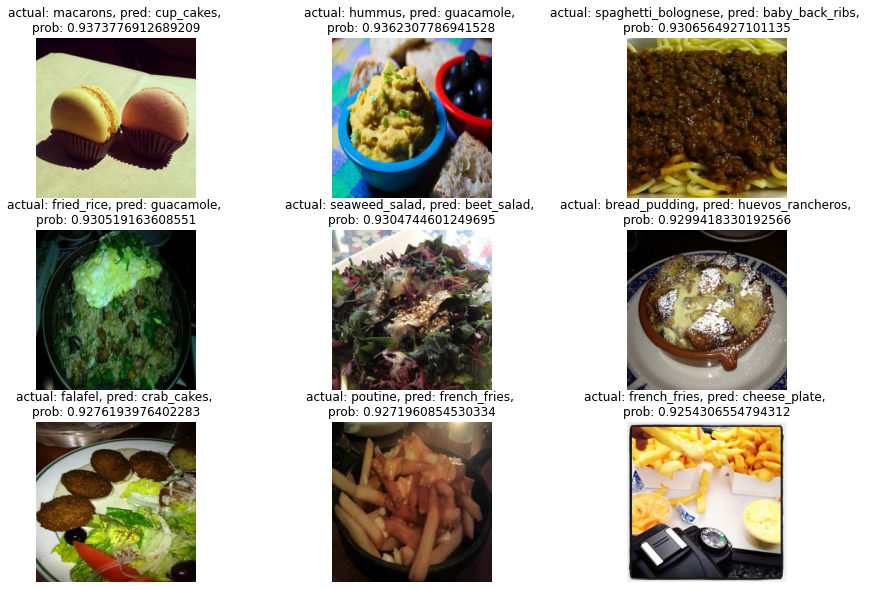

In [60]:
# I will write down what he does as well
num_images = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+num_images].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1])
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in a few parameters
  plt.imshow(img)
  plt.title(f'actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}')
  plt.axis('off')


## Test out the big dog model on our own custom images

In [62]:
# Get his images
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

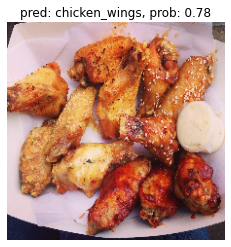

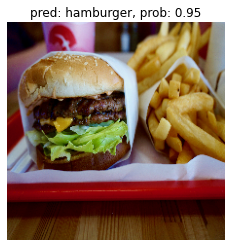

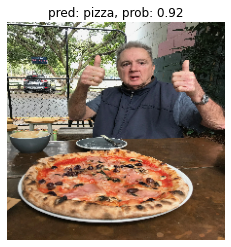

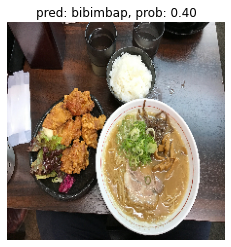

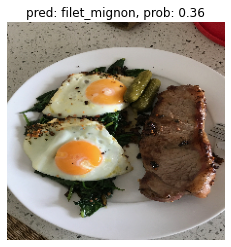

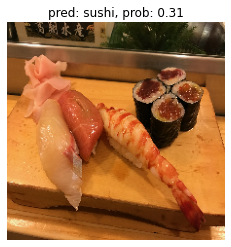

In [87]:
predicted_custom = []
for i in custom_food_images:
  img = load_and_prep_image(i, scale=False)
  custom_pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  #predicted_custom.append(loaded_model.predict(tf.expand_dims(img, axis=0)))
  custom_pred_class = class_names[custom_pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {custom_pred_class}, prob: {custom_pred_prob.max():.2f}')
  plt.axis(False)


In [84]:
predicted_custom_class = predicted_custom.argmax(axis=2)
predicted_custom_class


array([[20],
       [53],
       [76],
       [ 7],
       [37],
       [95]], dtype=int64)

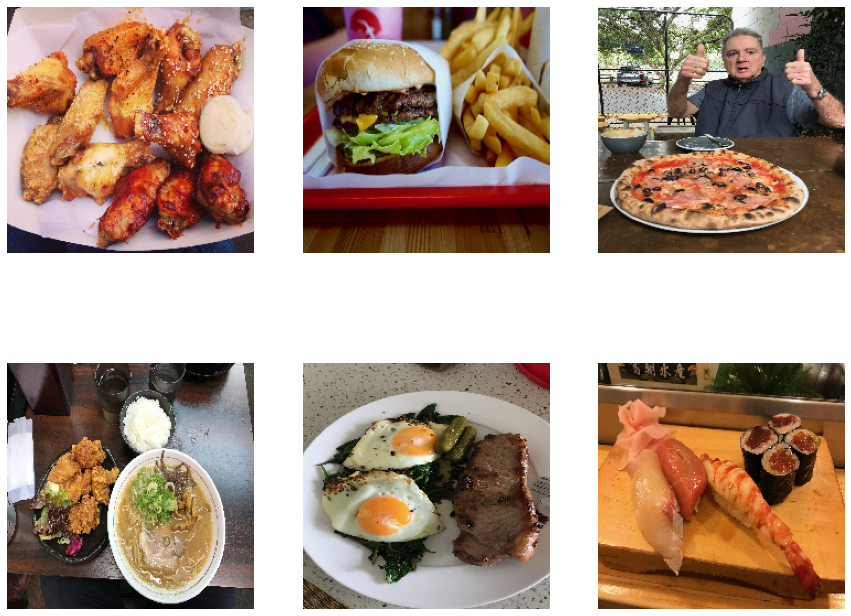

In [81]:
plt.figure(figsize=(15,12))
for i, it in enumerate(custom_food_images):
  plt.subplot(2, 3, i+1)
  img = load_and_prep_image(it)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'')

# Tasks for extra curriculum etc

In [88]:
# Task 1 compare 10 epoch straight and 5 epoch + 5 epoch fine tuning.
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data_10_percent,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=(0.10*len(test_data)),
                        )

Epoch 1/10
237/237 [==============================] - 192s 766ms/step - loss: 2.8692 - accuracy: 0.3209 - val_loss: 1.7022 - val_accuracy: 0.5578
Epoch 2/10
237/237 [==============================] - 124s 518ms/step - loss: 1.8108 - accuracy: 0.5325 - val_loss: 1.6431 - val_accuracy: 0.5783
Epoch 3/10
237/237 [==============================] - 123s 515ms/step - loss: 1.3902 - accuracy: 0.6316 - val_loss: 1.6200 - val_accuracy: 0.5803
Epoch 4/10
237/237 [==============================] - 126s 528ms/step - loss: 1.1463 - accuracy: 0.6822 - val_loss: 1.7357 - val_accuracy: 0.5601
Epoch 5/10
237/237 [==============================] - 102s 428ms/step - loss: 0.9239 - accuracy: 0.7432 - val_loss: 1.7972 - val_accuracy: 0.5566
Epoch 6/10
237/237 [==============================] - 95s 401ms/step - loss: 0.7753 - accuracy: 0.7823 - val_loss: 1.8513 - val_accuracy: 0.5621
Epoch 7/10
237/237 [==============================] - 91s 381ms/step - loss: 0.6196 - accuracy: 0.8217 - val_loss: 1.9803 - v

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
pip install tensorflow==2.5.0 --user

  Using cached tensorflow-2.5.0-cp37-cp37m-win_amd64.whl (422.6 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\robin\\appdata\\roaming\\python\\python37\\site-packages\\~ensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Check the permissions.



In [2]:
# Recreate the first model with mixed_precision turned on

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


**Note:** There seems to be an issue with the mixed precision and it is due to the version of tensorflow. Downgrade to 2.4.1

In [3]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [5]:
from helper_functions import *
data_augmentation = create_augmentation_layer()

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer', dtype='float32')

x = data_augmentation(inputs)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='ouput_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 (UUID: GPU-77f5af78-6bac-b8c2-db6b-cd9bf63c828d)


In [ ]:
# Compile and train the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_data_10_percent,
                        epochs=5)

Epoch 1/5
  3/237 [..............................] - ETA: 4:35:50 - loss: 4.6697 - accuracy: 0.0000e+00

In [5]:
import streamlit as st 
import pandas as pd

df = pd.DataFrame({
    'first column': [1, 2, 3, 4],
    'second column': [10, 20, 30, 40]
})
df

first column  second column
0             1             10
1             2             20
2             3             30
3             4             40

In [7]:
st.write('Here is our first attempt at using data to create a table:')
st.write(pd.DataFrame({
    'first column': [1, 2, 3, 4],
    'second column': [10, 20, 30, 40]
}))


In [9]:
import numpy as np
dataframe = np.random.randn(10, 20)
st.dataframe(dataframe)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [10]:
import streamlit as st
import numpy as np
import pandas as pd

dataframe = pd.DataFrame(
    np.random.randn(10, 20),
    columns=('col %d' % i for i in range(20)))

st.dataframe(dataframe.style.highlight_max(axis=0))

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [11]:
dataframe

col 0     col 1     col 2     col 3     col 4     col 5     col 6  \
0  0.468318 -0.833144  0.478256  1.882251  1.161101  0.334258 -0.293491   
1 -0.684127 -1.116201 -0.086345  0.633048 -1.015859  0.164519 -0.932734   
2  0.802280 -1.477125 -0.296979  0.005007  0.042164 -0.121803  0.651838   
3  0.178328 -0.320772  0.706364  0.151031  0.855226  0.484787  0.389679   
4  1.889704 -0.499332  0.094994  0.129840 -0.529425  0.440379 -2.690642   
5  0.119121  1.599992 -0.427334 -0.764028 -1.317672  0.924270 -0.294364   
6 -0.623000 -0.432600  0.998141 -0.453487 -0.854499 -2.482460 -0.640218   
7 -0.038808 -1.252967  0.744663 -1.244114  0.134718 -0.264632 -0.899893   
8 -0.166901  1.083860 -0.251243 -0.736831 -0.726851 -0.840669 -1.706655   
9  0.130637 -0.667032  0.587063  2.502399  1.641030 -0.674494 -0.863944   

      col 7     col 8     col 9    col 10    col 11    col 12    col 13  \
0 -0.042916  0.741755  0.240417  1.848375  0.696284  0.797503 -0.716406   
1 -1.224037 -0.074336 -1.009263  0.238141  0.787923 -0.116122  0.842968   
2 -0.848662 -0.565533 -2.058227  2.316641 -0.086342  0.606317  0.329737   
3  0.886920 -0.395030  0.338870  0.443843  1.373648  0.069567 -0.410555   
4 -0.236890  1.881033 -0.582070 -0.112786  1.146064  0.567483 -0.301874   
5 -0.072319  1.153037 -2.690751 -0.909984  0.010718 -0.081620 -0.336931   
6  0.277098  0.497262 -0.648833 -0.023225 -1.678668 -0.373851  0.991771   
7  1.826751 -1.258888  0.875504 -2.068722  0.361749 -1.129823 -0.129140   
8  0.144333 -0.457378 -1.555027 -2.018737  0.490273 -0.783005 -1.432808   
9 -0.172992  0.458008 -1.077710 -1.102402 -0.478498 -0.166419  1.971739   

     col 14    col 15    col 16    col 17    col 18    col 19  
0 -1.103976  0.596300  0.256856 -0.324622 -0.663567 -1.012880  
1  0.252120  0.663429  1.073410 -1.278532  0.105123  1.400477  
2 -0.599668  1.921894  0.443399 -1.007839 -0.840964  0.053739  
3 -1.580847  0.100555  0.840260 -1.058049  1.213562  0.881184  
4 -0.037920  1.138251 -0.326295 -1.227584  0.005765 -0.051417  
5 -1.764784  1.419901 -0.548312 -0.973837 -0.292643  1.868256  
6  0.021454  2.016668 -0.065705  0.675654 -0.769110  0.705098  
7  1.046616 -1.116836 -0.588627 -1.281477 -0.402510 -1.258153  
8  0.017786  0.280689 -0.237983  0.042436 -0.422181 -0.869460  
9 -2.410301 -1.604210  0.187012  0.222506 -0.079204 -2.477215

In [12]:
import streamlit as st
import numpy as np
import pandas as pd

chart_data = pd.DataFrame(
     np.random.randn(20, 3),
     columns=['a', 'b', 'c'])

st.line_chart(chart_data)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [13]:
chart_data

a         b         c
0   0.324283  0.222673  0.697494
1   1.167869  0.059479  1.519237
2   0.403476  0.350036  0.289225
3  -0.299773  1.190882  1.080272
4  -1.335602 -1.339277  0.952418
5   1.050239  0.530569 -1.131878
6  -0.411025 -0.342666 -0.658407
7   2.142454  0.810833  0.424860
8   0.596582  0.064265 -0.018073
9  -0.292262 -0.309982  0.171328
10 -0.100243  1.236977 -0.135440
11  0.553893  0.759297  0.289325
12 -0.544834  0.895719 -1.286078
13  0.551548  1.129973 -0.281124
14 -2.257004 -0.332636  0.022537
15 -0.252984  0.845758 -2.853248
16  0.179623  0.277688 -0.192475
17 -0.341036 -0.736793 -1.533739
18 -0.901286 -0.140027  0.140707
19  0.990134 -0.048202 -1.655604

In [16]:
import streamlit as st
import numpy as np
import pandas as pd

map_data = pd.DataFrame(
    np.random.randn(1000, 2) / [50, 50] + [37.76, -122.4],
    columns=['lat', 'lon'])

print(st.map(map_data))

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)


In [19]:
last_rows = np.random.randn(1, 1)
for i in range(1, 101):
  new_rows = last_rows[-1, :] + np.random.randn(5, 1).cumsum(axis=1)

new_rows

array([[ 0.18805259],
       [-0.0376422 ],
       [ 0.35521123],
       [ 0.27556022],
       [-1.05536412]])